In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

##  1. Loading and visual analysis of the dataset

In [2]:
UberData = pd.read_csv("Uber Request Data.csv")


In [3]:
UberData.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [4]:
UberData.shape

(6745, 6)

In [5]:
UberData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [6]:
UberData.Status.value_counts()

Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

In [7]:
UberData.dtypes.value_counts()

object     4
int64      1
float64    1
dtype: int64

In [8]:
UberData.select_dtypes(include=['object']).columns

Index(['Pickup point', 'Status', 'Request timestamp', 'Drop timestamp'], dtype='object')



Looking at s subset of the data and the definition of the features we notice:

    Status contains categorical values
    There are 6,745 rows with missing data in DriverID and Drop timestamp
    Both Request timestamp and Drop timestamp are of type object which needs to be casted
    DriverID is fload which needs to be integer
    This is a small dataset so we do not require further analysis on performance



##  2. Checking for Duplicates and NULL values

In [9]:
UberData.duplicated().sum()



0

In [10]:
UberData.isna().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [11]:
UberData.dtypes.value_counts()

object     4
int64      1
float64    1
dtype: int64

In [12]:
NA = UberData.isna().sum()/len(UberData)
NA[NA > 0].sort_values()

Driver id         0.392884
Drop timestamp    0.580282
dtype: float64

##  We see that Driver id and Drop timestamp are missing data


#### Check these 2 columns further to find any patteren and determine the best way to fill these NA

In [13]:
UberData[UberData['Driver id'].isna()]['Status'].unique()

array(['No Cars Available'], dtype=object)

In [14]:
UberData[UberData['Drop timestamp'].isna()]['Status'].unique()

array(['Cancelled', 'No Cars Available'], dtype=object)

####  From the above we notice that Driver ID is not available for rides that were not initiated Drop timestamp has missing values if the ride was not initiated or if the ride was cancelled for some reason. We do not have to worry about the NAs in these two fields as they are intended to be that way.

### 3. Feature selection

##### Purpose of our analysis to identify the possible reason for rides not being completed due to unavailability of cars. Looking at the columns available we know that DriverID and Drop timestamp is not going to be useful for this analysis.

In [15]:
UberData.drop(columns=['Driver id', 'Drop timestamp'],inplace = True)

## 4. Feature Engineering

## Renaming the columns to remove blank space and make the casing uniform

In [16]:
UberData.columns = [i.replace(' ', '_').lower() for i in UberData.columns]

##### Fixing the datatype


In [17]:
UberData['request_timestamp'] = pd.to_datetime(UberData['request_timestamp'])

### Lets add some new features which will perform detailed analysis


In [18]:
UberData['request_weekday'] = UberData[['request_timestamp']].apply(lambda x: dt.datetime.strftime(x['request_timestamp'], '%A'), axis=1)

In [19]:
UberData['request_weekday'].unique()

array(['Monday', 'Wednesday', 'Thursday', 'Friday'], dtype=object)

In [20]:
UberData['request_month'] = UberData[['request_timestamp']].apply(lambda x: dt.datetime.strftime(x['request_timestamp'], '%B'), axis=1)



In [21]:
UberData['request_month'].unique()

array(['November', 'December', 'July'], dtype=object)

In [22]:
UberData['request_year'] = UberData[['request_timestamp']].apply(lambda x: dt.datetime.strftime(x['request_timestamp'], '%Y'), axis=1)



In [23]:
UberData['request_year'].unique()

array(['2016'], dtype=object)

##  Our dataset is the requests made in the year 2016. Since it is just one year lets drop this feature

In [24]:
UberData.drop(columns=['request_year'],inplace = True)



In [25]:
UberData['Request_Hour'] = UberData['request_timestamp'].dt.round('H').dt.hour

In [26]:
UberData.rename(columns={"Request_Hour": "request_hour"}, inplace = True)

In [27]:
UberData['request_hour'].unique()

array([12, 18,  9, 21, 22,  6,  5,  7,  8, 14, 17, 10, 19, 11, 16,  3, 13,
       20,  2, 15, 23,  0,  4,  1], dtype=int64)

In [28]:
def get_hr(hr):
    if(hr >= 0 and hr <= 6):
        return 'Early Morning'
    elif(hr >= 7 and hr < 12):
        return 'Morning'
    elif(hr >= 12 and hr < 16):
        return 'Afternoon'
    elif(hr >= 16 and hr < 19):
        return 'Evening'
    elif(hr >= 19 and hr < 22):
        return 'Night'
    elif(hr >= 22):
        return 'Late Night'

In [29]:
UberData['time_of_day'] = UberData['request_hour'].apply(lambda x : get_hr(x))

## Our dataframe with new features


In [30]:
UberData.head()

,request_id,pickup_point,status,request_timestamp,request_weekday,request_month,request_hour,time_of_day
0,619,Airport,Trip Completed,2016-11-07 11:51:00,Monday,November,12,Afternoon
1,867,Airport,Trip Completed,2016-11-07 17:57:00,Monday,November,18,Evening
2,1807,City,Trip Completed,2016-12-07 09:17:00,Wednesday,December,9,Morning
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,Wednesday,December,21,Night
4,3112,City,Trip Completed,2016-07-13 08:33:16,Wednesday,July,9,Morning


##  5. Observation

In [31]:
# of rides being requested in each PickUp Point


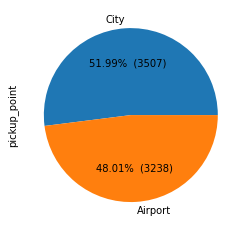

In [32]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

UberData['pickup_point'].value_counts().plot.pie(autopct=make_autopct(UberData['pickup_point'].value_counts()))
plt.show()

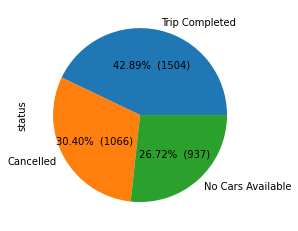

In [33]:
UberData[UberData.pickup_point == "City"]['status'].value_counts().plot.pie(autopct=make_autopct(UberData[UberData.pickup_point == "City"]['status'].value_counts()))
plt.show()

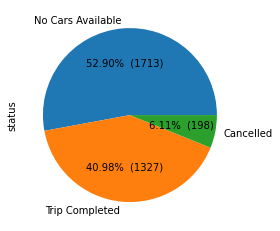

In [34]:
UberData[UberData.pickup_point == "Airport"]['status'].value_counts().plot.pie(autopct=make_autopct(UberData[UberData.pickup_point == "Airport"]['status'].value_counts()))
plt.show()

### Requests made on various days and time


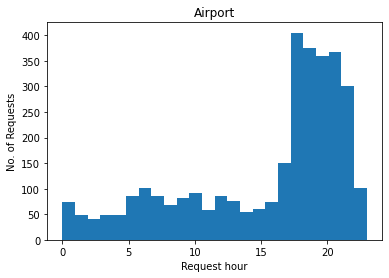

In [35]:
plt.hist(UberData[UberData.pickup_point == "Airport"]['request_hour'], bins=len(UberData['request_hour'].unique()))
plt.title("Airport")
plt.xlabel("Request hour")
plt.ylabel("No. of Requests")
plt.show()

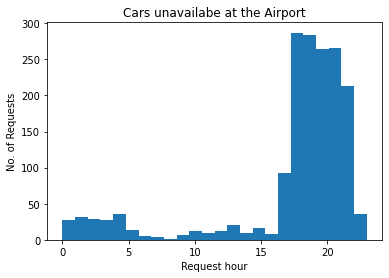

In [36]:
plt.hist(UberData[(UberData.pickup_point == "Airport") & (UberData.status == "No Cars Available")]['request_hour'], bins=len(UberData['request_hour'].unique()))
plt.title("Cars unavailabe at the Airport")
plt.xlabel("Request hour")
plt.ylabel("No. of Requests")
plt.show()

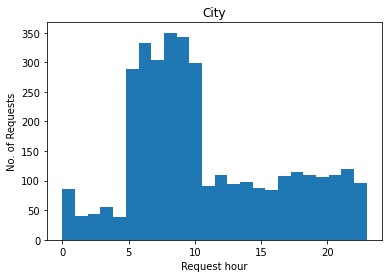

In [37]:
plt.hist(UberData[UberData.pickup_point == "City"]['request_hour'], bins=len(UberData['request_hour'].unique()))
plt.title("City")
plt.xlabel("Request hour")
plt.ylabel("No. of Requests")
plt.show()

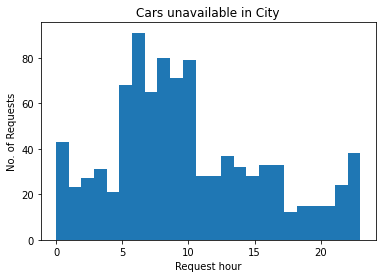

In [38]:
plt.hist(UberData[(UberData.pickup_point == "City") & (UberData.status == "No Cars Available")]['request_hour'], bins=len(UberData['request_hour'].unique()))
plt.title("Cars unavailable in City")
plt.xlabel("Request hour")
plt.ylabel("No. of Requests")
plt.show()

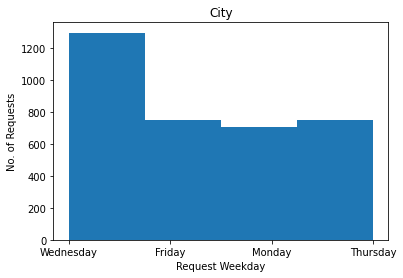

In [39]:
plt.hist(UberData[(UberData.pickup_point == "City")]['request_weekday'], bins=len(UberData['request_weekday'].unique()))
plt.title("City")
plt.xlabel("Request Weekday")
plt.ylabel("No. of Requests")
plt.show()

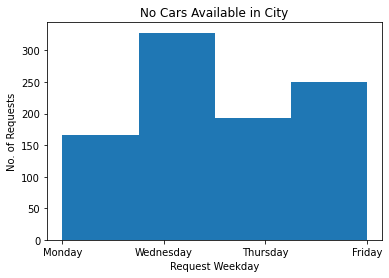

In [40]:
plt.hist(UberData[(UberData.pickup_point == "City") & (UberData.status == "No Cars Available")]['request_weekday'], bins=len(UberData['request_weekday'].unique()))
plt.title("No Cars Available in City")
plt.xlabel("Request Weekday")
plt.ylabel("No. of Requests")
plt.show()

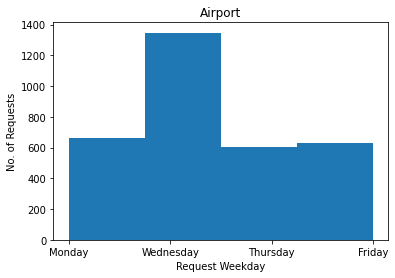

In [41]:


plt.hist(UberData[(UberData.pickup_point == "Airport")]['request_weekday'], bins=len(UberData['request_weekday'].unique()))
plt.title("Airport")
plt.xlabel("Request Weekday")
plt.ylabel("No. of Requests")
plt.show()



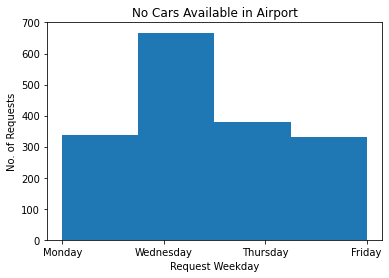

In [42]:
plt.hist(UberData[(UberData.pickup_point == "Airport") & (UberData.status == "No Cars Available")]['request_weekday'], bins=len(UberData['request_weekday'].unique()))
plt.title("No Cars Available in Airport")
plt.xlabel("Request Weekday")
plt.ylabel("No. of Requests")
plt.show()

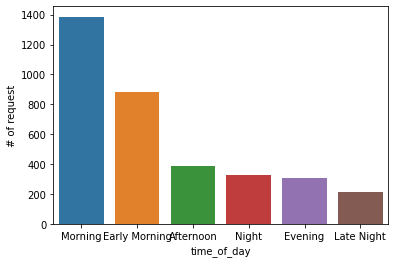

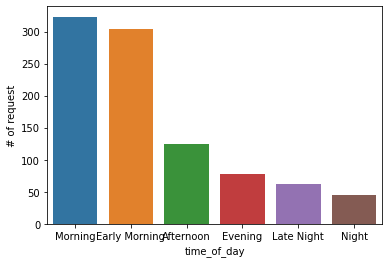

In [43]:


tdgrp = UberData[(UberData.pickup_point == "City")].groupby('time_of_day')['request_id'].count().reset_index(name='# of request').sort_values(by=["# of request"], ascending = False)
sns.barplot(x="time_of_day", y="# of request", data=tdgrp)
plt.show()

tdgrp = UberData[(UberData.pickup_point == "City") & (UberData.status == "No Cars Available")].groupby('time_of_day')['request_id'].count().reset_index(name='# of request').sort_values(by=["# of request"], ascending = False)
sns.barplot(x="time_of_day", y="# of request", data=tdgrp)
plt.show()



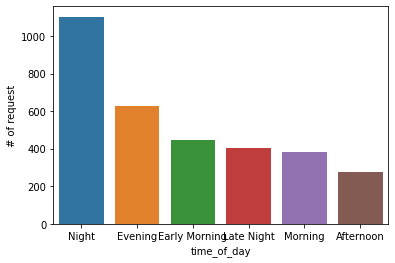

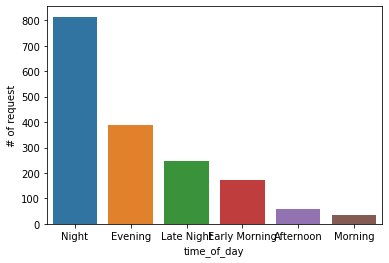

In [44]:
tdgrp = UberData[(UberData.pickup_point == "Airport")].groupby('time_of_day')['request_id'].count().reset_index(name='# of request').sort_values(by=["# of request"], ascending = False)
sns.barplot(x="time_of_day", y="# of request", data=tdgrp)
plt.show()
tdgrp = UberData[(UberData.pickup_point == "Airport") & (UberData.status == "No Cars Available")].groupby('time_of_day')['request_id'].count().reset_index(name='# of request').sort_values(by=["# of request"], ascending = False)
sns.barplot(x="time_of_day", y="# of request", data=tdgrp)
plt.show()

## Quick Summary on Cancelled Rides


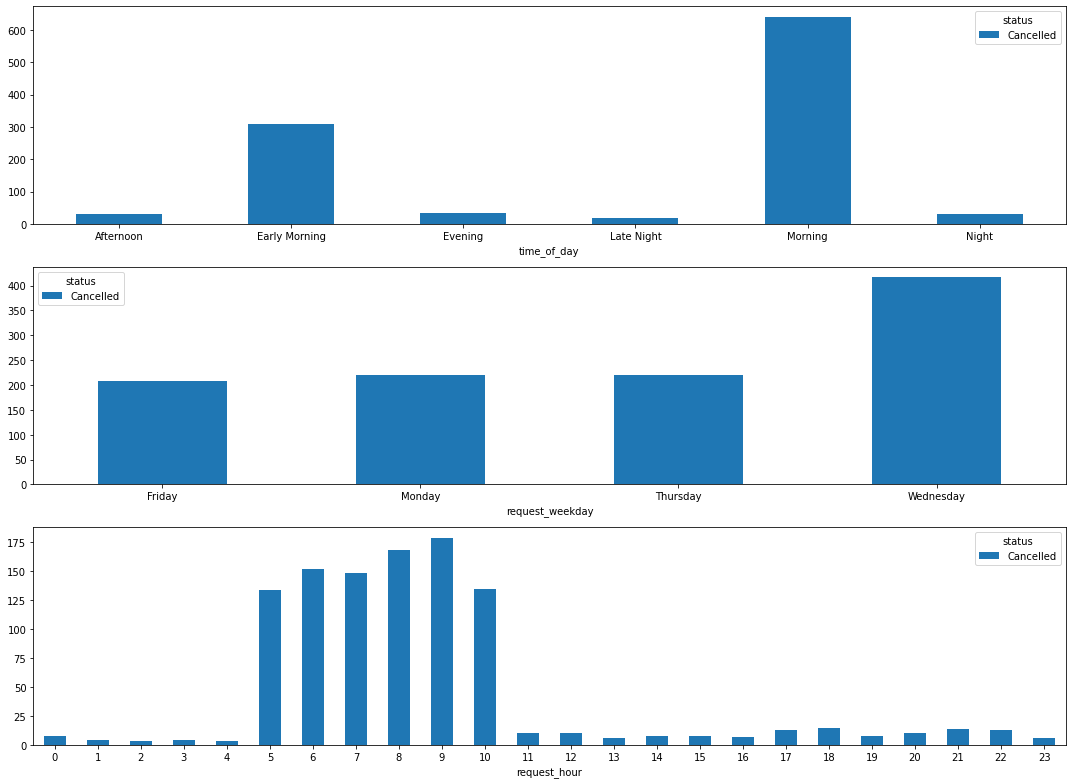

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(15, 11))
UberData[(UberData.status == "Cancelled") & (UberData.pickup_point == "City")].groupby(['time_of_day','status'])['request_id'].count().unstack().plot.bar(ax = axes[0],legend=True, rot=0)
UberData[(UberData.status == "Cancelled") & (UberData.pickup_point == "City")].groupby(['request_weekday','status'])['request_id'].count().unstack().plot.bar(ax = axes[1],legend=True, rot=0)
UberData[(UberData.status == "Cancelled") & (UberData.pickup_point == "City")].groupby(['request_hour','status'])['request_id'].count().unstack().plot.bar(ax = axes[2],legend=True, rot=0)
fig.tight_layout() 



## Summarizing the Stats by Status


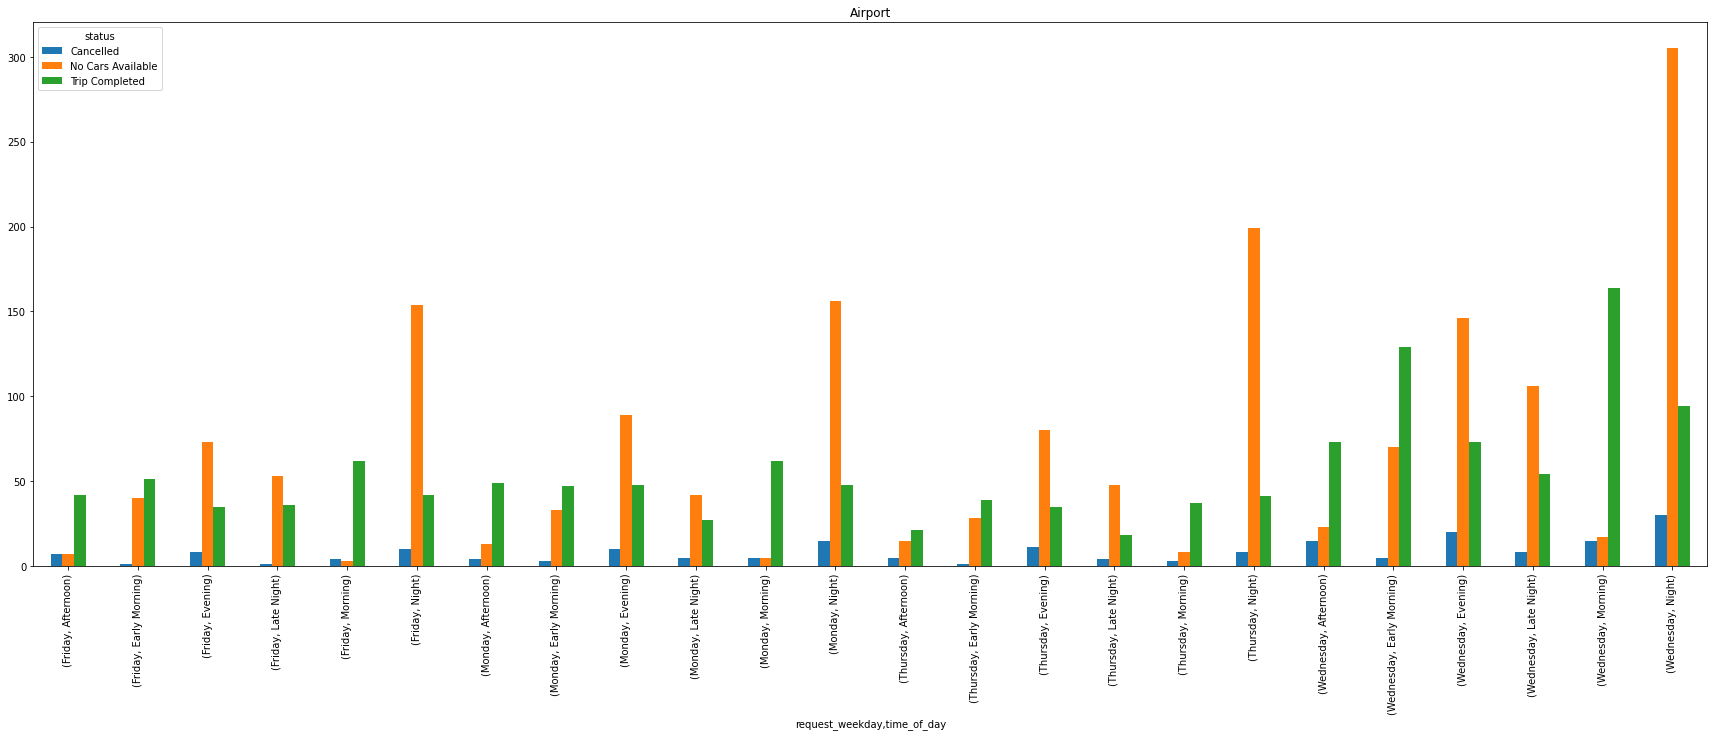

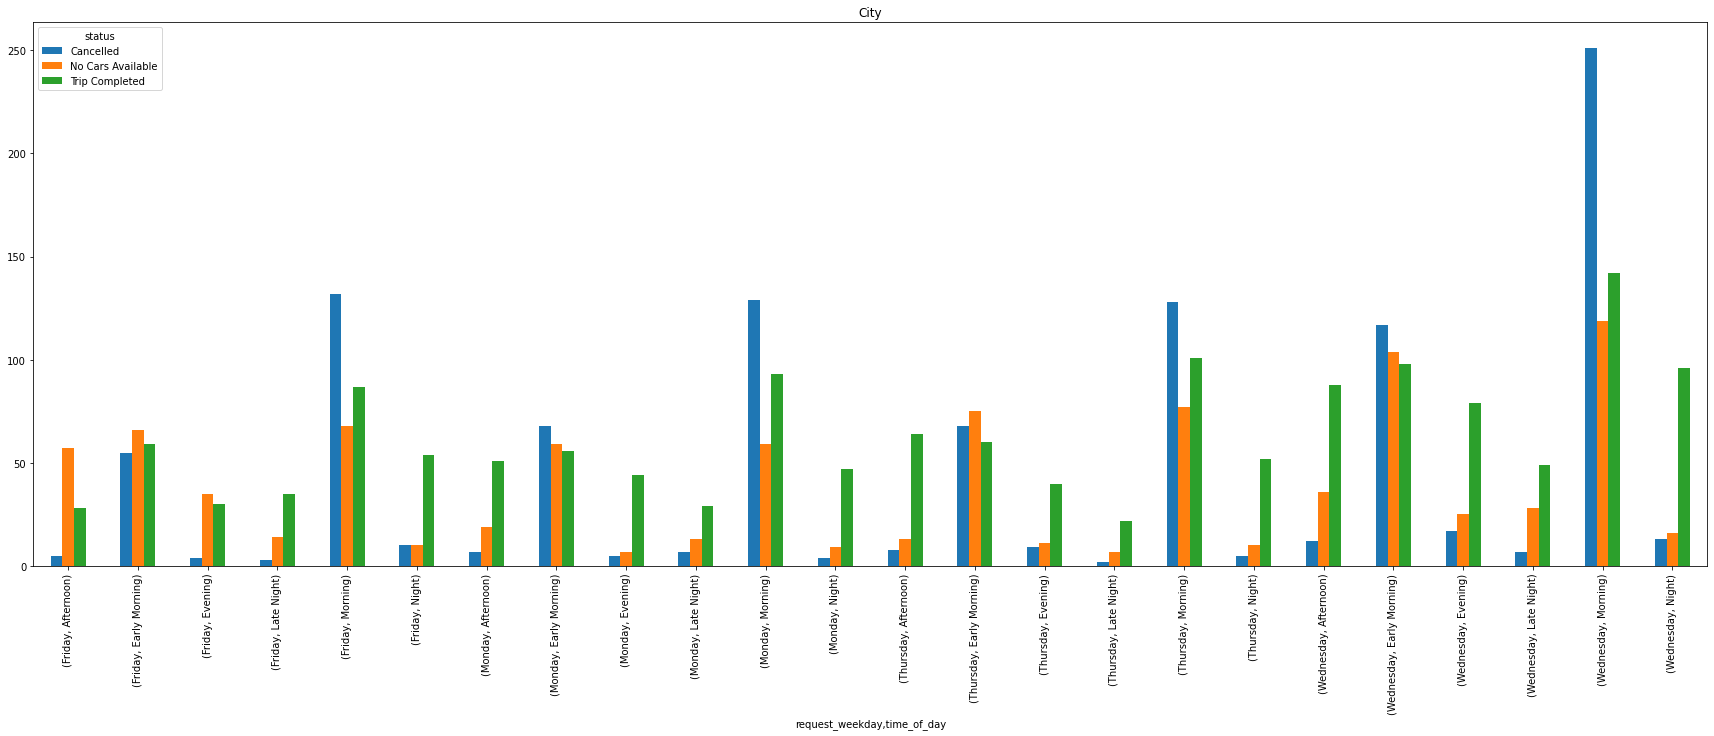

In [46]:
UberData[UberData.pickup_point == "Airport"].groupby(['request_weekday','time_of_day','status'])['request_id'].count().unstack().plot.bar(legend=True, figsize=(30,10))
plt.title("Airport")
plt.show()

UberData[UberData.pickup_point == "City"].groupby(['request_weekday','time_of_day','status'])['request_id'].count().unstack().plot.bar(legend=True, figsize=(30,10))
plt.title("City")
plt.show()

## 6. Summary